# IND5003 Enron Project
## Contents of this Jupyter Notebook
### Dataset
Dataset from Prof: 
(https://www.cs.cmu.edu/~./enron/)
- Unstructured Dataset containing raw text in the form of emails
**Make sure that the dataset 'maildir' is in the same directory as your project on your own system. Else this would not work**

## Approach to this Project

### Research Questions
(Use research questions to provide a narrative and storyline in our analysis of the Enron Email Corpus)

We would be taking a broad to narrow approach in terms of the narrative that we are looking to create. 

Some research questions that we would be hoping to analyse in this project are:
1. Are there any topical shifts that we can identify prior, leading up to and after the fraud has been exposed?
2. Can we detect sentiment shifts and anomalies in communication patterns leading up to, during and after the exposure of the fraud?
3. Identification of key individuals involved in the key discussions and anomalies in their comms patterns

#### Timeline

We have an intention to split our analysis into 3 defined timeframes:
1. Pre-Crisis (June 1999 - Aug 2001)
2. During Crisis ( Sep 2000 - Oct 2001 )
3. Post Crisis ( Nov 2001 - June 2002)

*** [GUYS WE NEED TO THINK OF THE DATES TO SPLIT THE TIMEFRAMES INTO. I WAS THINKING WE CAN FOLLOW JUST THE TIMELINE. THIS PART DEFINITELY HAVE TO STATE ASSUMPTIONS] ***

These research questions would be answered using a variety of NLP and Unsupervised Learning Techniques. 

*** [GUYS WE NEED TO THINK OF THE TECHNIQUES] ***
1. t-sne for initial identification of clusters
2. LDA for topic identification
3. Named entity recognition for trends in any entity
4. Sentimental Analysis
5. Anomaly detection (HOW?) 
6. Information retrieval to identify relevant individuals

### Overall Steps to Tackle this Project
1. Data Extraction
2. Data Cleaning & Preprocessing
3. Initial Data Exploration
    - Sender Frequency Analysis
    - Number of Emails Across Time
    - General topic modeling
    - General sentiment analysis
    - Word Cloud & Bar Charts for the Top Senders (20%)
    - Network Graph
    - t-sne graph
4. Research Questions
    1. Temporal Topical shifts using LDA Topic Modeling
    2. Temporal Sentimental Analysis - Segment the emails by quarters. Look at the way communication changes over time.
    3. Anomaly detection using?
    4. Key individual detection using?

    

### Section 1: Data Extraction
- Extract the emails from the unstructured raw folder


In [14]:
# Import the relevant libraries required for Section 1
import os # Required for directory traversal
import pandas as pd
import email
from email import policy
from email.parser import BytesParser
from collections import defaultdict
from itertools import islice

# additional libraries added for possible usage
import numpy as np
import pprint

import gensim
from gensim.parsing.preprocessing import *
import gensim.downloader as api
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import manifold

from transformers import pipeline

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import plotly.express as px


In [2]:
# Set the maildir path to the respective paths in your system 
# ! Note that maildir should be in the same directory as your project on your own system, would change if you are using windows
maildir_path = '/Users/Dylan/Documents/IND5003/Projects/maildir'

In [3]:
# Create a list of all the directories in the maildir for sanity check
maildir_list = os.listdir(maildir_path)
print(maildir_list)

['arnold-j', 'phanis-s', 'lavorato-j', 'stclair-c', 'townsend-j', 'forney-j', 'symes-k', 'reitmeyer-j', 'hyatt-k', 'steffes-j', 'kaminski-v', 'wolfe-j', 'mcconnell-m', 'skilling-j', 'zipper-a', 'shively-h', 'donoho-l', 'sanchez-m', 'delainey-d', 'germany-c', 'whalley-l', 'buy-r', 'harris-s', 'tholt-j', 'cash-m', 'sanders-r', '.DS_Store', 'staab-t', 'semperger-c', 'mccarty-d', 'mclaughlin-e', 'ring-a', 'stokley-c', 'hain-m', 'weldon-c', 'ring-r', 'farmer-d', 'sager-e', 'zufferli-j', 'ybarbo-p', 'watson-k', 'dasovich-j', 'arora-h', 'slinger-r', 'martin-t', 'storey-g', 'ruscitti-k', 'shankman-j', 'schwieger-j', 'perlingiere-d', 'saibi-e', 'griffith-j', 'meyers-a', 'grigsby-m', 'taylor-m', 'rapp-b', 'causholli-m', 'derrick-j', 'bass-e', 'south-s', 'salisbury-h', 'beck-s', 'tycholiz-b', 'shackleton-s', 'kitchen-l', 'merriss-s', 'blair-l', 'quenet-j', 'lokey-t', 'williams-j', 'panus-s', 'gang-l', 'hendrickson-s', 'schoolcraft-d', 'mann-k', 'kuykendall-t', 'allen-p', 'giron-d', 'lewis-a', 'jo

In [4]:
# def parse_email(file_path):
#     try:
#         with open(file_path, 'rb') as f:
#             msg = BytesParser(policy=policy.default).parse(f)
        
#         # Extract fields from the email
#         email_from = msg['From']
#         email_to = msg['To']
#         email_date = msg['Date']
#         email_subject = msg['Subject']
#         email_body = msg.get_body(preferencelist=('plain')).get_content() if msg.get_body(preferencelist=('plain')) else ''
        
#         return [email_from, email_to, email_date, email_subject, email_body]
#     except Exception as e:
#         print(f"Error parsing file {file_path}: {e}")
#         return None

# def batch_iterator(iterator, batch_size):
#     """Yield batches of specified size from an iterator."""
#     while True:
#         batch = list(islice(iterator, batch_size))
#         if not batch:
#             break
#         yield batch

# def load_emails(maildir_path, batch_size=10, max_emails=50):
#     email_data = []
#     file_paths = []

#     # Walk through the directory to collect file paths
#     for root, dirs, files in os.walk(maildir_path):
#         for file in files:
#             if file == '.DS_Store' or file.startswith('.'):
#                 continue  # Skip system files and hidden files
#             file_paths.append(os.path.join(root, file))
#             if len(file_paths) >= max_emails:
#                 break
#         if len(file_paths) >= max_emails:
#             break

#     # Process emails in batches
#     for batch in batch_iterator(iter(file_paths), batch_size):
#         batch_data = []
#         for file_path in batch:
#             result = parse_email(file_path)
#             if result is not None:
#                 batch_data.append(result)
        
#         # Append batch data to the main list
#         email_data.extend(batch_data)

#     # Create a DataFrame from the extracted data
#     df = pd.DataFrame(email_data, columns=['From', 'To', 'Date', 'Subject', 'Body'])
#     return df

# # Load and parse emails
# emails_df = load_emails(maildir_path, batch_size=10, max_emails=50)

# # Display the DataFrame
# print(emails_df.head())

### Loading the Data into a Pandas DF

In [9]:

# ! This is a very large dataset and will take a long time to run
# ! DO NOT RUN THIS FOR FUN UNLESS YOU WANT YOUR COMPUTER TO CRASH
def parse_email(file_path):
    try:
        with open(file_path, 'rb') as f:
            msg = BytesParser(policy=policy.default).parse(f)
        
        # Extract fields from the email
        email_from = msg['From']
        email_to = msg['To']
        email_date = msg['Date']
        email_subject = msg['Subject']
        email_body = msg.get_body(preferencelist=('plain')).get_content() if msg.get_body(preferencelist=('plain')) else ''
        
        return [email_from, email_to, email_date, email_subject, email_body]
    except Exception as e:
        print(f"Error parsing file {file_path}: {e}")
        return None

def batch_iterator(iterator, batch_size):
    """Yield batches of specified size from an iterator."""
    while True:
        batch = list(islice(iterator, batch_size))
        if not batch:
            break
        yield batch

def load_emails(maildir_path, batch_size=1000):
    email_data = []
    file_paths = []

    # Walk through the directory to collect file paths
    for root, dirs, files in os.walk(maildir_path):
        for file in files:
            if file == '.DS_Store' or file.startswith('.'):
                continue  # Skip system files and hidden files
            file_paths.append(os.path.join(root, file))

    # Process emails in batches
    for batch in batch_iterator(iter(file_paths), batch_size):
        batch_data = []
        for file_path in batch:
            result = parse_email(file_path)
            if result is not None:
                batch_data.append(result)
        
        # Append batch data to the main list
        email_data.extend(batch_data)

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(email_data, columns=['From', 'To', 'Date', 'Subject', 'Body'])
    return df

# Load and parse emails
emails_df = load_emails(maildir_path, batch_size=1000)

# Display the DataFrame
print(emails_df.head())

Error parsing file /Users/Dylan/Documents/IND5003/Projects/maildir/kitchen-l/sent_items/24.: 'ValueTerminal' object does not support item assignment
Error parsing file /Users/Dylan/Documents/IND5003/Projects/maildir/kitchen-l/_americas/netco_eol/83.: 'ValueTerminal' object does not support item assignment
Error parsing file /Users/Dylan/Documents/IND5003/Projects/maildir/kitchen-l/_americas/netco_eol/82.: 'ValueTerminal' object does not support item assignment
Error parsing file /Users/Dylan/Documents/IND5003/Projects/maildir/kitchen-l/_americas/esvl/87.: 'ValueTerminal' object does not support item assignment
Error parsing file /Users/Dylan/Documents/IND5003/Projects/maildir/kitchen-l/_americas/netco_restart/3.: 'ValueTerminal' object does not support item assignment
                        From  \
0            msagel@home.com   
1    slafontaine@globalp.com   
2    iceoperations@intcx.com   
3  jeff.youngflesh@enron.com   
4  caroline.abramo@enron.com   

                            

In [10]:
# Convert emails_df to a CSV file
# Save the DataFrame as a CSV file in the specified directory

#emails_df.to_csv('/Users/Dylan/Documents/IND5003/Projects/emails_uncleaned.csv', index=False)


In [2]:
# Load the CSV file back into a DataFrame

# PLEASE CHANGE IT TO YOUR OWN DIRECTORY IN YOUR OWN SYSTEM 

# Load the CSV file back into a DataFrame

# PLEASE CHANGE IT TO YOUR OWN DIRECTORY IN YOUR OWN SYSTEM 

enron_uncleaned_emails = pd.read_csv('data/enron_emails_uncleaned.csv')

In [3]:
enron_uncleaned_emails.head()

,From,To,Date,Subject,Body
0,msagel@home.com,jarnold@enron.com,"Thu, 16 Nov 2000 09:30:00 -0800",Status,John:\n?\nI'm not really sure what happened be...
1,slafontaine@globalp.com,john.arnold@enron.com,"Fri, 08 Dec 2000 05:05:00 -0800",re:summer inverses,i suck-hope youve made more money in natgas la...
2,iceoperations@intcx.com,"icehelpdesk@intcx.com, internalmarketing@intcx...","Tue, 15 May 2001 09:43:00 -0700",The WTI Bullet swap contracts,"Hi,\n\n\n Following the e-mail you have rece..."
3,jeff.youngflesh@enron.com,"anthony.gilmore@enron.com, colleen.koenig@enro...","Mon, 27 Nov 2000 01:49:00 -0800",Invitation: EBS/GSS Meeting w/Bristol Babcock ...,Conference Room TBD. \n\nThis meeting will be...
4,caroline.abramo@enron.com,mike.grigsby@enron.com,"Tue, 12 Dec 2000 09:33:00 -0800",Harvard Mgmt,Mike- I have their trader coming into the offi...


In [4]:
# Find "kitchen" in the column "From"

# This is to determine that there are still emails sent from louise kitchen despite the original parsing error due to the encoding of the email
kitchen_emails = enron_uncleaned_emails[enron_uncleaned_emails['From'].str.contains('kitchen', case=False, na=False)]
print(kitchen_emails)

                            From  \
617     louise.kitchen@enron.com   
874     louise.kitchen@enron.com   
910     louise.kitchen@enron.com   
926     louise.kitchen@enron.com   
5072    louise.kitchen@enron.com   
...                          ...   
503415  louise.kitchen@enron.com   
503507  louise.kitchen@enron.com   
509732  louise.kitchen@enron.com   
509790  louise.kitchen@enron.com   
509829  louise.kitchen@enron.com   

                                                       To  \
617                                 john.arnold@enron.com   
874     tim.belden@enron.com, f..calger@enron.com, m.....   
910     wes.colwell@enron.com, georgeanne.hodges@enron...   
926                                    c..bland@enron.com   
5072                              john.lavorato@enron.com   
...                                                   ...   
503415  rob.milnthorp@enron.com, f..calger@enron.com, ...   
503507  rob.milnthorp@enron.com, f..calger@enron.com, ...   
509732  k..allen@e

## Section 2: Data Preprocessing
### Start with the Cleaning
* Check for any nulls
* Drop the missing values
* Remove the duplicates
* Format the dates 



In [4]:
# Check for Nulls in Each Column
missing_values = enron_uncleaned_emails.isnull().sum()
missing_values_df = pd.DataFrame({'Column': missing_values.index, 'Missing Values': missing_values.values})
print(missing_values_df)

    Column  Missing Values
0     From               0
1       To           21847
2     Date               0
3  Subject           19187
4     Body               0


In [5]:
# Description of the DataFrame
enron_uncleaned_emails.describe()

,From,To,Date,Subject,Body
count,517396,495549,517396,498209,517396
unique,20326,58556,224119,159286,249020
top,kay.mann@enron.com,pete.davis@enron.com,"Wed, 27 Jun 2001 16:02:00 -0700",RE:,"As you know, Enron Net Works (ENW) and Enron G..."
freq,16735,9155,1118,6477,112


In [6]:
# Fill out the missing values with empty strings
enron_cleaned_emails = enron_uncleaned_emails.fillna('')

In [7]:
# Post cleaning Check
missing_values_check = enron_cleaned_emails.isnull().sum()
missing_values_df_check = pd.DataFrame({'Column': missing_values_check.index, 'Missing Values': missing_values_check.values})
print(missing_values_df_check)

    Column  Missing Values
0     From               0
1       To               0
2     Date               0
3  Subject               0
4     Body               0


In [8]:
# Describe the cleaned DataFrame
enron_cleaned_emails.describe()

,From,To,Date,Subject,Body
count,517396,517396,517396,517396,517396
unique,20326,58557,224119,159287,249020
top,kay.mann@enron.com,,"Wed, 27 Jun 2001 16:02:00 -0700",,"As you know, Enron Net Works (ENW) and Enron G..."
freq,16735,21847,1118,19187,112


* From running the code above, the output would show that there are 249020 emails with unique bodies out of the 517396 emails. 
    * This means that ~51.9% of emails in the uncleaned dataframe are not unique
    * This would ensure that the subsequent analytical metrics (when performing LDA, TFIDF, Word2vec) are not inflated. 

In [9]:
# Remove duplicate emails based on the 'Body' column, keeping only the first occurrence
enron_cleaned_emails_body_unique = enron_cleaned_emails.drop_duplicates(subset=['Body'], keep='first')

# Describe the DataFrame after removing duplicates
enron_cleaned_emails_body_unique.describe()

,From,To,Date,Subject,Body
count,249020,249020,249020,249020,249020
unique,20129,58069,219084,158462,249020
top,jeff.dasovich@enron.com,,"Wed, 27 Jun 2001 16:02:00 -0700",,John:\n?\nI'm not really sure what happened be...
freq,5486,9024,1118,8577,1


In [11]:
# # When running the code block above, i observed that jeff dasovich sent the most emails. 
# # Now i want to explore the number of emails he sent
# # Filter emails where 'From' is 'jeff.dasovich@enron.com'
# jeff_emails = enron_cleaned_emails_body_unique[enron_cleaned_emails_body_unique['From'] == 'jeff.dasovich@enron.com']

# # Count the number of emails he sent
# jeff_emails_count = jeff_emails.shape[0]

# # Display the count
# print(f"Jeff Dasovich sent {jeff_emails_count} emails.")

# # Display the first few rows of Jeff's emails
# jeff_emails.head()


Jeff Dasovich sent 5486 emails.


,From,To,Date,Subject,Body
27219,jeff.dasovich@enron.com,d..steffes@enron.com,"Tue, 23 Oct 2001 14:25:50 -0700",RE:,thanks.\n\n -----Original Message-----\nFrom: ...
27277,jeff.dasovich@enron.com,"ginger.dernehl@enron.com, d..steffes@enron.com...","Wed, 17 Oct 2001 14:43:57 -0700",RE: Golf - November Direct Report Meeting,Yes.\n\n -----Original Message-----\nFrom: \tD...
27332,jeff.dasovich@enron.com,"d..steffes@enron.com, susan.mara@enron.com","Tue, 23 Oct 2001 17:02:14 -0700",FW: Stipulation Comments,I asked Mike Day to make sure that we were kep...
27334,jeff.dasovich@enron.com,"d..steffes@enron.com, susan.mara@enron.com","Mon, 22 Oct 2001 11:52:32 -0700",FW: Angelides Oct. 19th Letter to L. Lynch Urg...,FYI. Here's a note I sent to the large custom...
27369,jeff.dasovich@enron.com,c..williams@enron.com,"Fri, 26 Oct 2001 11:28:06 -0700",RE: Edison meet and confer call,Let's try this. It's all inter-related. PG&E...


In [10]:
# Convert the Date column to a pandas datetime object
enron_cleaned_emails['Date'] = pd.to_datetime(enron_cleaned_emails['Date'], errors='coerce', utc='False')

# Print the types of each column to ensure that the Date column is now a datetime object
enron_cleaned_emails.dtypes

From                    object
To                      object
Date       datetime64[ns, UTC]
Subject                 object
Body                    object
dtype: object

In [11]:
# Create a table with the number of emails sent every year
enron_cleaned_emails['Year'] = enron_cleaned_emails['Date'].dt.year
emails_per_year = enron_cleaned_emails['Year'].value_counts().sort_index()
emails_per_year_df = pd.DataFrame({'Year': emails_per_year.index, 'Emails': emails_per_year.values})
print(emails_per_year_df)

    Year  Emails
0   1980     522
1   1986       2
2   1997     437
3   1998     177
4   1999   11144
5   2000  196100
6   2001  272964
7   2002   35969
8   2004      70
9   2005       1
10  2007       1
11  2012       2
12  2020       2
13  2024       1
14  2043       1
15  2044       3


In [33]:
# Create another column with the months of each row
enron_cleaned_emails['Month'] = enron_cleaned_emails['Date'].dt.month
# group the dataframe by Year and Month and cont the number of items in each index
emails_per_month_year = enron_cleaned_emails.groupby(['Year','Month']).count()['From']

In [52]:
# Check the number of emails in 2002 divided by month
emails_per_month_year[2002]

Month
1     21077
2      8199
3      3452
4      1159
5       909
6       921
7       244
9         6
10        1
12        1
Name: From, dtype: int64

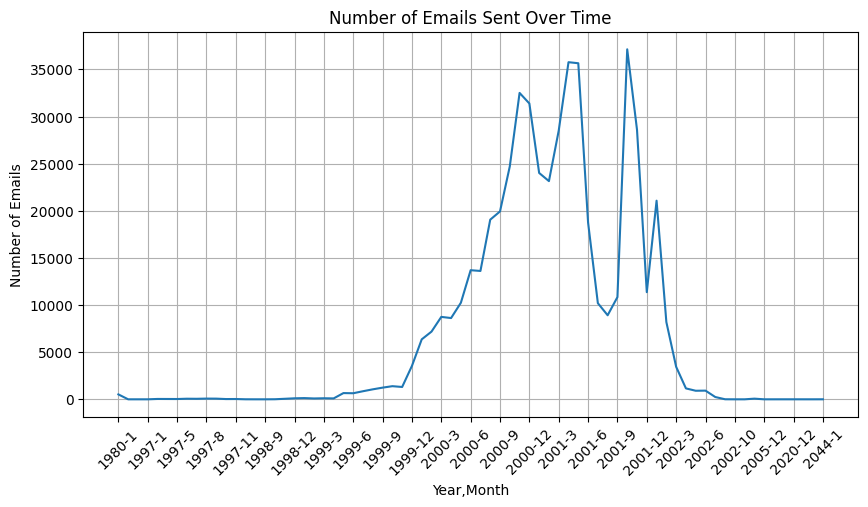

In [47]:
# Create large plot size
plt.figure(figsize=(10, 5))
emails_per_month_year.plot()
# Add tick marks in the x axis for every 3 months
plt.xticks(np.arange(0, len(emails_per_month_year), step=3), rotation=45,
           labels=[f"{year}-{month}" for year, month in emails_per_month_year.index][::3])
plt.ylabel('Number of Emails')
plt.title('Number of Emails Sent Over Time')
plt.grid()
plt.show()

We can see that emails start jumping up around December 1999, inreasing to its' peak at around Oct 2001 with notable decrease around August 2001. Afterwards the number of emails in the data set decreases until around June 2002. 

In [53]:
# Divide the enron cleaned emails into 3 dataframes,

# The first dataframe for dates between June 1999 and August 2000
enron_pre_crisis = enron_cleaned_emails[(enron_cleaned_emails['Date'] >= '1999-06-01') & (enron_cleaned_emails['Date'] <= '2000-08-31')]
 
# The second dataframe for dates between Sep 2000 to Oct 2001
enron_during_crisis = enron_cleaned_emails[(enron_cleaned_emails['Date'] >= '2000-09-01') & (enron_cleaned_emails['Date'] <= '2001-10-31')]

# The third dataframe for dates between November 2001 to June 2002
enron_post_crisis = enron_cleaned_emails[(enron_cleaned_emails['Date'] >= '2001-11-01') & (enron_cleaned_emails['Date'] <= '2002-06-30')]